In [1]:
import pandas as pd
import os

csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
]

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df[combined_df["Label"] != 0]
cols = [col for col in combined_df.columns if col != "Label"] + ["Label"]
combined_df = combined_df[cols]
combined_df = combined_df.drop(columns=["patch_entropy","x","y"])

output_csv = "data_final.csv"
combined_df.to_csv(output_csv, index=False)
print(f"Combined data saved to {output_csv}")

Combined data saved to data_final.csv


## Logistic Regression

For the logistic regression, we need to check whether the multicollinearity is present in the data by checking the VIF values. If the VIF values are greater than 10, then we need to remove the variable from the data.

Also the independence of each observation is assumed in the logistic regression. However, it is unlikely since our data comes from 3 plots so inevitably there will be some correlation between the observations especially within the same plot.



In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('data_final.csv')

# For Logistic Regression, I tested and found that pca_feature has a high VIF score
# So I removed it from the dataset
data = data.drop(columns=['pca_feature'])

# Also, I found that the 'grad_mean' and 'patch_range' have high VIF scores
# Since they both measure the sparsity of the image, I combined them into one feature by PCA
cols_to_scale = ['grad_mean', 'patch_range']
pca = PCA(n_components=1)
data['combined_feature'] = pca.fit_transform(data[cols_to_scale])
data = data.drop(columns=cols_to_scale)

print(data.head())


        ae0       ae1       ae2       ae3       ae4       ae5       ae6  \
0  1.197294  0.266305  1.328071 -0.056179  0.472661  0.203686  0.002540   
1  1.107397  0.192222  1.249997  0.009110  0.413045  0.060429  0.198304   
2  1.184946  0.005137  1.192648  0.038367  0.350369 -0.243404  0.435510   
3  1.413633 -0.091881  1.331789 -0.438865  0.169667 -0.417025  0.070926   
4  1.523770 -0.253262  1.382754 -0.538834  0.197273 -0.352385 -0.096838   

        ae7      NDAI           SD      CORR  Label  combined_feature  
0 -1.142211  0.177196  2132.407715  0.586117   -1.0          5.486118  
1 -1.222439  0.024248  2017.497681  0.710036   -1.0          5.521759  
2 -0.862849 -0.011466  3542.883057  0.904450   -1.0          5.584542  
3 -0.136777  0.337512  3234.484619  0.775055   -1.0          5.455872  
4  0.156666  0.401247  1751.852783  0.206298   -1.0          5.580096  


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = data.drop('Label', axis=1)
# Map labels from {-1, 1} to {0, 1} No cloud = 0, Cloud = 1
y = data['Label'].map({-1.0: 0, 1.0: 1})  

# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=928)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=910)

print("Data shape:", X.shape)
print("Training set:", X_train.shape, "Training positives:", y_train.sum())
print("Validation set:", X_val.shape, "Validation positives:", y_val.sum())
print("Test set:", X_test.shape, "Test positives:", y_test.sum())

Data shape: (207681, 12)
Training set: (124608, 12) Training positives: 48579
Validation set: (41536, 12) Validation positives: 16193
Test set: (41537, 12) Test positives: 16193


In [12]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

def evaluate_model(model, X, y, cv):
    scoring = ['accuracy', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(scores['test_accuracy']), np.mean(scores['test_roc_auc'])

# Set up 10-fold cross-validation repeated 10 times
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

# Logistic Regression model
lr_pipeline = Pipeline([('scaler', StandardScaler()),('clf', LogisticRegression(solver='lbfgs', max_iter=500, random_state=635))])
lr_acc, lr_auc = evaluate_model(lr_pipeline, X_train, y_train, cv)
print(f"Logistic Regression: Accuracy = {lr_acc:.3f}, ROC AUC = {lr_auc:.3f}")

# Calculate AIC
X_train_sm = sm.add_constant(StandardScaler().fit_transform(X_train))
lr_model_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)
print("Logistic Regression AIC:", lr_model_sm.aic)

# Calculate test set performance
lr_pipeline.fit(X_train, y_train)
lr_test_acc = lr_pipeline.score(X_test, y_test)
print(f"Logistic Regression Test Set Accuracy: {lr_test_acc:.3f}")
y_test_pred = lr_pipeline.predict_proba(X_test)[:, 1]
lr_test_auc = roc_auc_score(y_test, y_test_pred)
print(f"Logistic Regression Test Set ROC AUC: {lr_test_auc:.3f}")

# The Coefficients of the logistic regression model
print('Coefficients:')
print(lr_model_sm.params)

# Permuation Importance

# PCA_feature is the proportion of variance explained by the first PC in the patch
lr_pipeline.fit(X_train, y_train)
lr_perm = permutation_importance(lr_pipeline, X_val, y_val, n_repeats=10, random_state=313)
importances_df_lr = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': lr_perm['importances_mean'],
    'std_importance': lr_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_lr)

Logistic Regression: Accuracy = 0.948, ROC AUC = 0.971
Logistic Regression AIC: 51981.32217926727
Logistic Regression Test Set Accuracy: 0.949
Logistic Regression Test Set ROC AUC: 0.971
Coefficients:
const   -0.420658
x1       2.007840
x2       0.699245
x3       0.238618
x4      -1.745901
x5       0.951351
x6       1.916410
x7      -0.778888
x8      -1.250210
x9       1.157630
x10      0.197559
x11      0.599191
x12     -0.417663
dtype: float64
             feature  mean_importance  std_importance
0                ae0         0.142479        0.000650
5                ae5         0.075749        0.001494
3                ae3         0.061573        0.001103
7                ae7         0.052530        0.000532
8               NDAI         0.038071        0.001043
4                ae4         0.024054        0.000669
6                ae6         0.023016        0.000485
10              CORR         0.012115        0.000787
1                ae1         0.010868        0.000267
11  combin

In [6]:
import pandas as pd
import numpy as np

odds_ratios = np.exp(lr_model_sm.params)
odds_ratio_df = pd.DataFrame({
    'feature': ['Intercept'] + list(X.columns), 
    'odds_ratio': odds_ratios.values
})

odds_ratio_df = odds_ratio_df.sort_values('odds_ratio', ascending=False)
print(odds_ratio_df)

             feature  odds_ratio
1                ae0    7.447216
6                ae5    6.796518
9               NDAI    3.182382
5                ae4    2.589204
2                ae1    2.012232
11              CORR    1.820645
3                ae2    1.269494
10                SD    1.218425
12  combined_feature    0.658584
0          Intercept    0.656615
7                ae6    0.458916
8                ae7    0.286445
4                ae3    0.174488


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for finding multicollinearity
vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif)


            Variable       VIF
0                ae0  2.050839
1                ae1  1.260729
2                ae2  2.542699
3                ae3  1.158184
4                ae4  1.826448
5                ae5  2.678760
6                ae6  1.153501
7                ae7  1.586266
8               NDAI  7.624124
9                 SD  4.597940
10              CORR  3.511048
11  combined_feature  3.287316


# Decision Tree



In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Select a few hyperparameters
param_grid = {
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]}

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=2001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= 918)

# Setup GridSearchCV to tune hyperparameters based on ROC AUC.
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
    )

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC score from CV:", grid_search.best_score_)

# Evaluate the best model on the validation set.
best_dt_model = grid_search.best_estimator_
y_val_pred = best_dt_model.predict(X_val)
y_val_score = best_dt_model.predict_proba(X_val)[:, 1]
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_score)
print("Best Decision Tree on Validation Set: Accuracy =", val_acc, ", ROC AUC =", val_auc)

Fitting 100 folds for each of 8 candidates, totalling 800 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best ROC AUC score from CV: 0.989922430465703
Best Decision Tree on Validation Set: Accuracy = 0.9695926425269645 , ROC AUC = 0.9907959260381518


In [9]:
#Use the best hyperparameters to train the model
dt_model_best = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_pipeline = Pipeline([('scaler', StandardScaler()),('clf', dt_model_best)])
dt_acc, dt_auc = evaluate_model(dt_pipeline, X_train, y_train, cv)
print(f"Decision Tree: Accuracy = {dt_acc:.3f}, ROC AUC = {dt_auc:.3f}")

# Permuation Importance
dt_pipeline.fit(X_train, y_train)
dt_perm = permutation_importance(dt_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_dt = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': dt_perm['importances_mean'],
    'std_importance': dt_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_dt)


Decision Tree: Accuracy = 0.968, ROC AUC = 0.990
             feature  mean_importance  std_importance
9                 SD         0.135740        0.001232
5                ae5         0.059878        0.001067
0                ae0         0.041015        0.000791
10              CORR         0.040124        0.000688
3                ae3         0.017917        0.000350
4                ae4         0.013511        0.000440
6                ae6         0.011980        0.000234
7                ae7         0.010085        0.000306
8               NDAI         0.008633        0.000347
11  combined_feature         0.008268        0.000242
2                ae2         0.007254        0.000259
1                ae1         0.003185        0.000210



MDI Feature Importances:


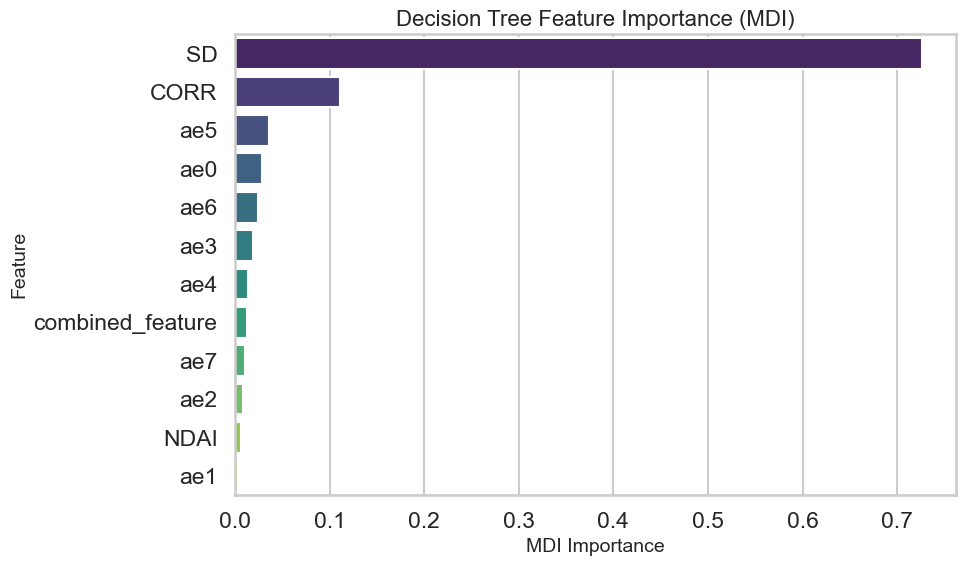

In [10]:
# MDI+ 
import seaborn as sns
import matplotlib.pyplot as plt

mdi_importances = dt_pipeline.named_steps['clf'].feature_importances_

importances_df_mdi = pd.DataFrame({
    'feature': X.columns,
    'mdi_importance': mdi_importances
}).sort_values('mdi_importance', ascending=False)

print("\nMDI Feature Importances:")
sns.set_theme(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importances_df_mdi, x='mdi_importance', y='feature', ax=ax, palette='viridis')
ax.set_title('Decision Tree Feature Importance (MDI)', fontsize=16)
ax.set_xlabel('MDI Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.neural_network import MLPClassifier

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state= 918)

# Neural Network model
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(20,), max_iter=300, random_state=788))
])

# Cross-validate the Neural Network
nn_acc, nn_auc = evaluate_model(nn_pipeline, X_train, y_train, cv)
print(f"Neural Network CV: Accuracy = {nn_acc:.3f}, ROC AUC = {nn_auc:.3f}")

# Fit the MLP on the training set and evaluate on the validation set
nn_pipeline.fit(X_train, y_train)
y_val_pred = nn_pipeline.predict(X_val)
if hasattr(nn_pipeline, "predict_proba"):
    y_val_score = nn_pipeline.predict_proba(X_val)[:, 1]
else:
    y_val_score = nn_pipeline.decision_function(X_val)
print("Neural Network on Validation Set: Accuracy =", accuracy_score(y_val, y_val_pred),
      "ROC AUC =", roc_auc_score(y_val, y_val_score))



Neural Network CV: Accuracy = 0.982, ROC AUC = 0.998
Neural Network on Validation Set: Accuracy = 0.9819915254237288 ROC AUC = 0.9984374914674952


In [15]:
# Permuation Importance for NN

nn_perm = permutation_importance(nn_pipeline, X_val, y_val, n_repeats=10, random_state=313)
importances_df_nn = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': nn_perm['importances_mean'],
    'std_importance': nn_perm['importances_std']
}).sort_values('mean_importance', ascending=False)
print(importances_df_nn)


             feature  mean_importance  std_importance
0                ae0         0.173938        0.001725
5                ae5         0.082574        0.001322
11  combined_feature         0.059517        0.001010
4                ae4         0.040654        0.000805
2                ae2         0.038945        0.000581
9                 SD         0.030992        0.000735
7                ae7         0.026661        0.000403
6                ae6         0.023057        0.000269
3                ae3         0.022884        0.000508
1                ae1         0.017700        0.000697
8               NDAI         0.015859        0.000616
10              CORR         0.010846        0.000436


AE5 and AE0 are two of the most important features in the dataset across all the models we have.

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [19:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.948807  0.948865  0.948750  0.948865
1        Decision Tree   0.968645  0.968534  0.968567  0.968534
2       Neural Network   0.951481  0.945591  0.946073  0.945591
3              XGBoost   0.993778  0.993765  0.993767  0.993765


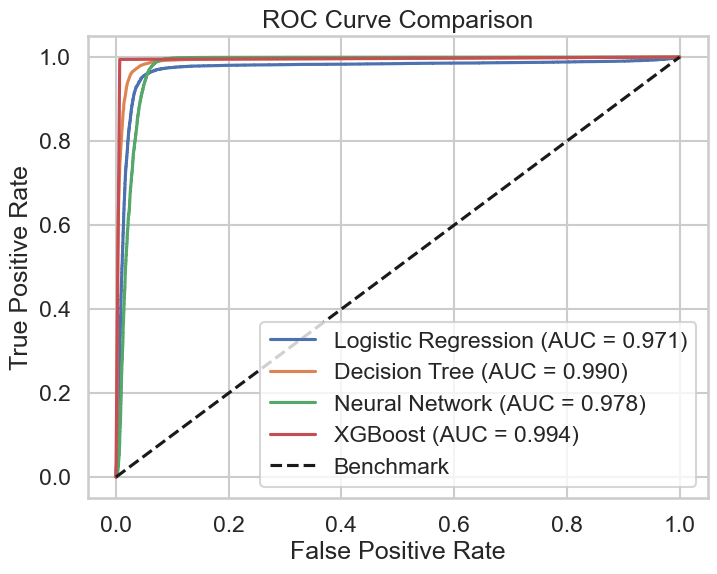

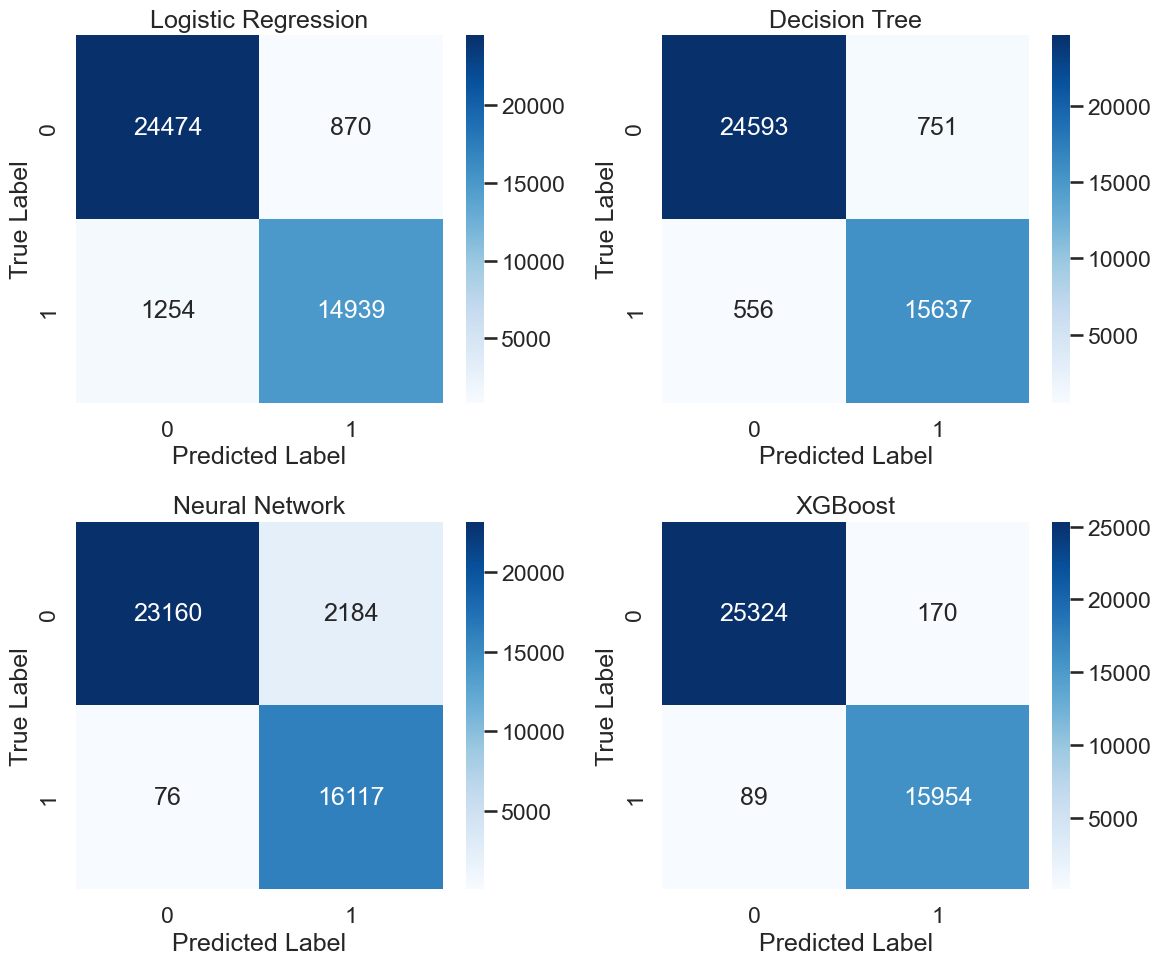

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict_proba(X_test)[:, 1]

dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]

nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=788)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict_proba(X_test)[:, 1]

data = pd.read_csv("data_final.csv")
features_XG = ["ae0", "ae1", "ae2", "ae3", "ae4", "ae5", "ae6", "ae7", "NDAI", "SD", "CORR", "pca_feature", "grad_mean", "patch_range"]
target = "Label"
X_train_XG, X_test_XG, y_train_XG, y_test_XG = train_test_split(data[features_XG], data[target], test_size=0.2, random_state=42)
y_train_XG = y_train_XG.replace({-1: 0, 1: 1})
y_test_XG = y_test_XG.replace({-1: 0, 1: 1})
model_XG = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
model_XG.fit(X_train_XG, y_train_XG)
y_pred_XG = model_XG.predict(X_test_XG)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
fpr_XG, tpr_XG, _ = roc_curve(y_test_XG, y_pred_XG)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_nn = auc(fpr_nn, tpr_nn)
auc_XG = auc(fpr_XG, tpr_XG)

y_pred_lr_bi = (y_pred_lr > 0.5).astype(int)
y_pred_dt_bi = (y_pred_dt > 0.5).astype(int)
y_pred_nn_bi = (y_pred_nn > 0.5).astype(int)
y_pred_XG_bi = (y_pred_XG > 0.5).astype(int)

report_lr = classification_report(y_test, y_pred_lr_bi, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt_bi, output_dict=True)
report_nn = classification_report(y_test, y_pred_nn_bi, output_dict=True)
report_XG = classification_report(y_test_XG, y_pred_XG_bi, output_dict=True)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bi)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_bi)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn_bi)
conf_matrix_XG = confusion_matrix(y_test_XG, y_pred_XG_bi)

classification_reports_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Neural Network", "XGBoost"],
    "Precision": [report_lr["weighted avg"]["precision"], report_dt["weighted avg"]["precision"], report_nn["weighted avg"]["precision"], report_XG["weighted avg"]["precision"]],
    "Recall": [report_lr["weighted avg"]["recall"], report_dt["weighted avg"]["recall"], report_nn["weighted avg"]["recall"], report_XG["weighted avg"]["recall"]],
    "F1-score": [report_lr["weighted avg"]["f1-score"], report_dt["weighted avg"]["f1-score"], report_nn["weighted avg"]["f1-score"], report_XG["weighted avg"]["f1-score"]],
    "Accuracy": [report_lr["accuracy"], report_dt["accuracy"], report_nn["accuracy"], report_XG["accuracy"]],
})

print(classification_reports_df)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.3f})')
plt.plot(fpr_XG, tpr_XG, label=f'XGBoost (AUC = {auc_XG:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Benchmark')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

def plot_confusion_matrix_subplot(ax, y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'{model_name}')

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_confusion_matrix_subplot(axs[0, 0], y_test, y_pred_lr_bi, "Logistic Regression")
plot_confusion_matrix_subplot(axs[0, 1], y_test, y_pred_dt_bi, "Decision Tree")
plot_confusion_matrix_subplot(axs[1, 0], y_test, y_pred_nn_bi, "Neural Network")
plot_confusion_matrix_subplot(axs[1, 1], y_test_XG, y_pred_XG_bi, "XGBoost")

plt.tight_layout()
plt.show()

## Use a different approach to seperate the training, validation and test data

Leave-one-image-out cross-validation is used to evaluate the model performance. The model is trained on n-1 observations and tested on the remaining observation. Since we have only 3 plots, we can use this method to evaluate the model performance.

In [17]:
csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
] 

for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["Label"] != 0]
    cols = [col for col in df.columns if col != "Label"] + ["Label"]
    df = df[cols]
    df = df.drop(columns=["patch_entropy", "x", "y"], errors='ignore')
    output_file = f"{file.replace('_merged.csv', '_modified.csv').split('/')[-1]}"  
    df.to_csv(output_file, index=False)
    print(f"Modified data saved to {output_file}")


Modified data saved to dataset\O012791_modified.csv
Modified data saved to dataset\O013257_modified.csv
Modified data saved to dataset\O013490_modified.csv


In [19]:
train_val_files = [
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O012791_modified.csv",
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013257_modified.csv"
]
test_file = "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013490_modified.csv"

# We use the first two datasets for training and validation
# The third dataset is used for testing
train_val_df = pd.concat([pd.read_csv(file) for file in train_val_files], ignore_index=True)
test_df = pd.read_csv(test_file)

train_val_df = train_val_df.drop(columns=['pca_feature'])
test_df = test_df.drop(columns=['pca_feature'])

cols_to_scale = ['grad_mean', 'patch_range']
scaler = StandardScaler()
pca = PCA(n_components=1)

train_val_df[cols_to_scale] = scaler.fit_transform(train_val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])  

train_val_df['combined_feature'] = pca.fit_transform(train_val_df[cols_to_scale])
test_df['combined_feature'] = pca.transform(test_df[cols_to_scale])

train_val_df = train_val_df.drop(columns=cols_to_scale)
test_df = test_df.drop(columns=cols_to_scale)

X = train_val_df.drop('Label', axis=1)
y = train_val_df['Label'].map({-1.0: 0, 1.0: 1}) 

# 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = test_df.drop('Label', axis=1)
y_test = test_df['Label'].map({-1.0: 0, 1.0: 1})

def evaluate_model(model, X, y, cv):
    scoring = ['accuracy', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return np.mean(scores['test_accuracy']), np.mean(scores['test_roc_auc'])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(solver='lbfgs', max_iter=500, random_state=635))])

lr_acc, lr_auc = evaluate_model(lr_pipeline, X_train, y_train, cv)
print(f"Logistic Regression: Accuracy = {lr_acc:.3f}, ROC AUC = {lr_auc:.3f}")
X_train_sm = sm.add_constant(StandardScaler().fit_transform(X_train))
lr_model_sm = sm.Logit(y_train, X_train_sm).fit(disp=0)
print("Logistic Regression AIC:", lr_model_sm.aic)

print('Coefficients:')
print(lr_model_sm.params)

lr_pipeline.fit(X_train, y_train)
lr_perm = permutation_importance(lr_pipeline, X_val, y_val, n_repeats=10, random_state=313, n_jobs=-1)
importances_df_lr = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': lr_perm['importances_mean'],
    'std_importance': lr_perm['importances_std']
}).sort_values('mean_importance', ascending=False)

print(importances_df_lr)



Logistic Regression: Accuracy = 0.940, ROC AUC = 0.959
Logistic Regression AIC: 51521.7060003782
Coefficients:
const   -1.187544
x1       2.341232
x2       0.725253
x3       0.092945
x4      -1.628897
x5       1.072315
x6       1.424629
x7      -0.869219
x8      -1.191616
x9       0.352683
x10     -0.098388
x11      0.794335
x12     -0.097606
dtype: float64
             feature  mean_importance  std_importance
0                ae0         0.209411        0.001722
3                ae3         0.073778        0.001643
7                ae7         0.061947        0.001131
5                ae5         0.060876        0.001048
4                ae4         0.045060        0.000984
6                ae6         0.039013        0.000667
10              CORR         0.023316        0.000957
1                ae1         0.017568        0.000673
8               NDAI         0.004180        0.000506
11  combined_feature         0.000462        0.000291
9                 SD         0.000342        0

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Select a few hyperparameters
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]}

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=2001)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state= 918)

# Setup GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
    )

grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best ROC AUC score from CV:", grid_search.best_score_)

# Evaluate the best model
best_dt_model = grid_search.best_estimator_
y_val_pred = best_dt_model.predict(X_val)
y_val_score = best_dt_model.predict_proba(X_val)[:, 1]
val_acc = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_score)
print("Best Decision Tree on Validation Set: Accuracy =", val_acc, ", ROC AUC =", val_auc)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best ROC AUC score from CV: 0.9856201217915124
Best Decision Tree on Validation Set: Accuracy = 0.9606687898089172 , ROC AUC = 0.9872247733667272


C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [19:39:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.966924  0.966412  0.966427  0.966412
1        Decision Tree   0.959551  0.957628  0.957644  0.957628
2       Neural Network   0.946145  0.945884  0.945903  0.945884
3              XGBoost   0.976267  0.975427  0.975439  0.975427


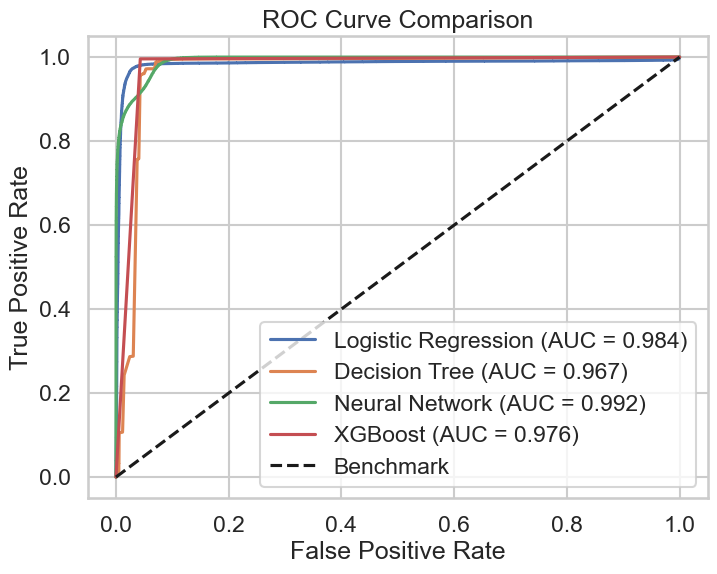

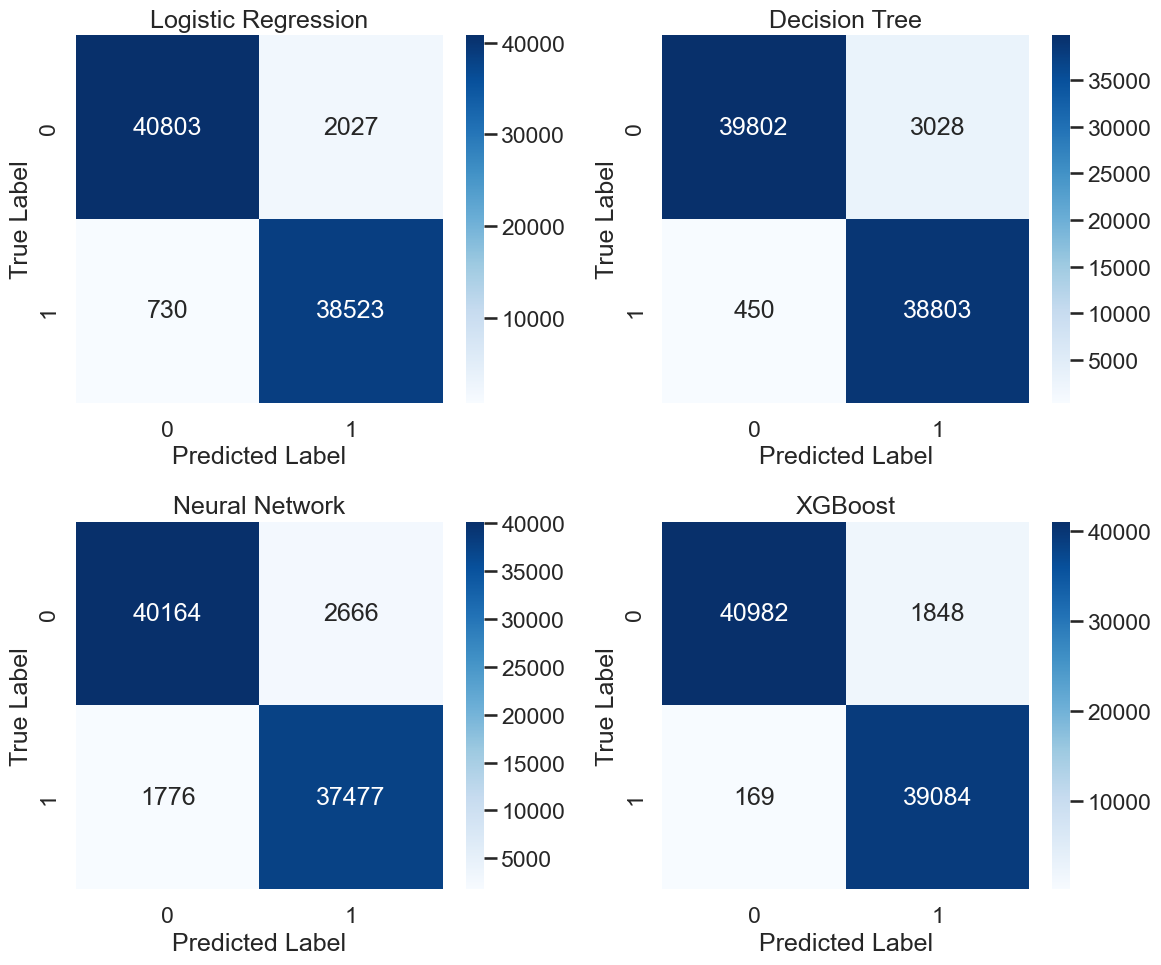

In [22]:
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict_proba(X_test)[:, 1]

dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=200)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict_proba(X_test)[:, 1]

nn_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=788)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict_proba(X_test)[:, 1]

model_XG = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
model_XG.fit(X_train, y_train)
y_pred_XG = model_XG.predict(X_test)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
fpr_XG, tpr_XG, _ = roc_curve(y_test, y_pred_XG)

auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_nn = auc(fpr_nn, tpr_nn)
auc_XG = auc(fpr_XG, tpr_XG)


y_pred_lr_bi = (y_pred_lr > 0.5).astype(int)
y_pred_dt_bi = (y_pred_dt > 0.5).astype(int)
y_pred_nn_bi = (y_pred_nn > 0.5).astype(int)
y_pred_XG_bi = (y_pred_XG > 0.5).astype(int)

report_lr = classification_report(y_test, y_pred_lr_bi, output_dict=True)
report_dt = classification_report(y_test, y_pred_dt_bi, output_dict=True)
report_nn = classification_report(y_test, y_pred_nn_bi, output_dict=True)
report_XG = classification_report(y_test, y_pred_XG_bi, output_dict=True)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr_bi)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt_bi)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn_bi)
conf_matrix_XG = confusion_matrix(y_test, y_pred_XG_bi)

classification_reports_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Neural Network", "XGBoost"],
    "Precision": [report_lr["weighted avg"]["precision"], report_dt["weighted avg"]["precision"], report_nn["weighted avg"]["precision"], report_XG["weighted avg"]["precision"]],
    "Recall": [report_lr["weighted avg"]["recall"], report_dt["weighted avg"]["recall"], report_nn["weighted avg"]["recall"], report_XG["weighted avg"]["recall"]],
    "F1-score": [report_lr["weighted avg"]["f1-score"], report_dt["weighted avg"]["f1-score"], report_nn["weighted avg"]["f1-score"], report_XG["weighted avg"]["f1-score"]],
    "Accuracy": [report_lr["accuracy"], report_dt["accuracy"], report_nn["accuracy"], report_XG["accuracy"]],
})

print(classification_reports_df)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.3f})')
plt.plot(fpr_XG, tpr_XG, label=f'XGBoost (AUC = {auc_XG:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Benchmark')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_confusion_matrix_subplot(axs[0, 0], y_test, y_pred_lr_bi, "Logistic Regression")
plot_confusion_matrix_subplot(axs[0, 1], y_test, y_pred_dt_bi, "Decision Tree")
plot_confusion_matrix_subplot(axs[1, 0], y_test, y_pred_nn_bi, "Neural Network")
plot_confusion_matrix_subplot(axs[1, 1], y_test, y_pred_XG_bi, "XGBoost")

plt.tight_layout()
plt.show()


In [23]:
lr_l2_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=635))
])

param_grid = {'clf__C': [1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]}  

grid_search = GridSearchCV(lr_l2_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Optimal lambda = {1/grid_search.best_params_['clf__C']:.4f}")
print(f"Optimal AUC = {grid_search.best_score_:.4f}")

best_lr_model = grid_search.best_estimator_
y_pred_lr_best = best_lr_model.predict_proba(X_test)[:, 1]

fpr_lr_best, tpr_lr_best, _ = roc_curve(y_test, y_pred_lr_best)
auc_lr_best = auc(fpr_lr_best, tpr_lr_best)
y_pred_lr_best_bi = best_lr_model.predict(X_test)

report_lr_best = classification_report(y_test, y_pred_lr_best_bi, output_dict=True)
conf_matrix_lr_best = confusion_matrix(y_test, y_pred_lr_best_bi)

print(f"Best Logistic Regression: AUC = {auc_lr_best:.3f}")
print("Classification Report:")
print(classification_reports_df)

Optimal lambda = 100.0000
Optimal AUC = 0.9589
Best Logistic Regression: AUC = 0.984
Classification Report:
                 Model  Precision    Recall  F1-score  Accuracy
0  Logistic Regression   0.966924  0.966412  0.966427  0.966412
1        Decision Tree   0.959551  0.957628  0.957644  0.957628
2       Neural Network   0.946145  0.945884  0.945903  0.945884
3              XGBoost   0.976267  0.975427  0.975439  0.975427


In [24]:
from sklearn.feature_selection import SequentialFeatureSelector

base_lr = LogisticRegression(penalty='l2', C=grid_search.best_params_['clf__C'], solver='lbfgs', max_iter=500, random_state=635)
sfs = SequentialFeatureSelector(base_lr, n_features_to_select=8, direction="backward", cv=10, scoring="roc_auc", n_jobs=-1)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print(f" Selected features: {list(selected_features)}")

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
base_lr.fit(X_train_selected, y_train)
y_pred_lr_selected = base_lr.predict_proba(X_test_selected)[:, 1]

fpr_lr_selected, tpr_lr_selected, _ = roc_curve(y_test, y_pred_lr_selected)
auc_lr_selected = auc(fpr_lr_selected, tpr_lr_selected)

y_pred_lr_selected_bi = base_lr.predict(X_test_selected)
report_lr_selected = classification_report(y_test, y_pred_lr_selected_bi, output_dict=True)

print(f"Selected Logistic Regression: AUC = {auc_lr_selected:.3f}")
print("Classification Report:")
report_lr_selected


 Selected features: ['ae0', 'ae1', 'ae3', 'ae4', 'ae5', 'ae6', 'ae7', 'CORR']
Selected Logistic Regression: AUC = 0.981
Classification Report:


{'0': {'precision': 0.9792146144994246,
  'recall': 0.9536539808545412,
  'f1-score': 0.9662652882590902,
  'support': 42830},
 '1': {'precision': 0.9508310420846647,
  'recall': 0.9779125162407969,
  'f1-score': 0.9641816537727318,
  'support': 39253},
 'accuracy': 0.9652546812372842,
 'macro avg': {'precision': 0.9650228282920447,
  'recall': 0.9657832485476691,
  'f1-score': 0.965223471015911,
  'support': 82083},
 'weighted avg': {'precision': 0.9656412757082429,
  'recall': 0.9652546812372842,
  'f1-score': 0.9652688711630649,
  'support': 82083}}

In [25]:
csv_files = [
    "dataset\\O012791_merged.csv",
    "dataset\\O013257_merged.csv",
    "dataset\\O013490_merged.csv"
] 

for file in csv_files:
    df = pd.read_csv(file)
    df = df[df["Label"] != 0]
    cols = [col for col in df.columns if col != "Label"] + ["Label"]
    df = df[cols]
    df = df.drop(columns=["patch_entropy"], errors='ignore')
    output_file = f"{file.replace('_merged.csv', '_modified_withxy.csv').split('/')[-1]}"  
    df.to_csv(output_file, index=False)
    print(f"Modified data saved to {output_file}")


Modified data saved to dataset\O012791_modified_withxy.csv
Modified data saved to dataset\O013257_modified_withxy.csv
Modified data saved to dataset\O013490_modified_withxy.csv


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_val_files = [
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O012791_modified_withxy.csv",
    "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013257_modified_withxy.csv"
]
test_file = "C:/Users/lenovo/Desktop/stats214/lab2wzh/dataset/O013490_modified_withxy.csv"

train_val_df = pd.concat([pd.read_csv(file) for file in train_val_files], ignore_index=True)
test_df = pd.read_csv(test_file)

train_val_xy = train_val_df[['x', 'y']].copy()
test_xy = test_df[['x', 'y']].copy()

# delete the pca_feature column
train_val_df = train_val_df.drop(columns=['pca_feature'])
test_df = test_df.drop(columns=['pca_feature'])

cols_to_scale = ['grad_mean', 'patch_range']
scaler = StandardScaler()
pca = PCA(n_components=1)

train_val_df[cols_to_scale] = scaler.fit_transform(train_val_df[cols_to_scale])
test_df[cols_to_scale] = scaler.transform(test_df[cols_to_scale])

train_val_df['combined_feature'] = pca.fit_transform(train_val_df[cols_to_scale])
test_df['combined_feature'] = pca.transform(test_df[cols_to_scale])

train_val_df = train_val_df.drop(columns=cols_to_scale)
test_df = test_df.drop(columns=cols_to_scale)

# Map labels from {-1, 1} to {0, 1} No cloud = 0, Cloud = 1
X = train_val_df.drop(['Label'], axis=1)
y = train_val_df['Label'].map({-1.0: 0, 1.0: 1})

X_train, X_val, y_train, y_val, train_xy, val_xy = train_test_split(
    X, y, train_val_xy, test_size=0.2, random_state=42, stratify=y
)

X_test = test_df.drop(['Label'], axis=1)
y_test = test_df['Label'].map({-1.0: 0, 1.0: 1})
test_xy = test_xy.reset_index(drop=True)


In [27]:
lr_l2_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=635))
])

param_grid = {'clf__C': [1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6]}  

grid_search = GridSearchCV(lr_l2_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Optimal lambda = {1/grid_search.best_params_['clf__C']:.4f}")
print(f"Optimal AUC = {grid_search.best_score_:.4f}")

best_lr_model = grid_search.best_estimator_
y_pred_lr_best = best_lr_model.predict_proba(X_test)[:, 1]

fpr_lr_best, tpr_lr_best, _ = roc_curve(y_test, y_pred_lr_best)
auc_lr_best = auc(fpr_lr_best, tpr_lr_best)
y_pred_lr_best_bi = best_lr_model.predict(X_test)

report_lr_best = classification_report(y_test, y_pred_lr_best_bi, output_dict=True)
conf_matrix_lr_best = confusion_matrix(y_test, y_pred_lr_best_bi)

misclassified_idx = np.where(y_test != y_pred_lr_best_bi)[0]
X_misclassified = X_test.iloc[misclassified_idx]
y_misclassified = y_test.iloc[misclassified_idx]

Optimal lambda = 100.0000
Optimal AUC = 0.9641


Misclassified true label 0:
          x      y  count
0      78.0  370.0      1
1      79.0  369.0      1
2      79.0  370.0      1
3      80.0  331.0      1
4      80.0  335.0      1
...     ...    ...    ...
1286  367.0   22.0      1
1287  367.0   23.0      1
1288  367.0   24.0      1
1289  367.0   25.0      1
1290  367.0   26.0      1

[1291 rows x 3 columns]
(1291, 3)

Misclassified true label 1:
         x      y  count
0     66.0  288.0      1
1     66.0  289.0      1
2     66.0  290.0      1
3     66.0  291.0      1
4     66.0  292.0      1
..     ...    ...    ...
710  366.0   78.0      1
711  366.0   79.0      1
712  367.0   77.0      1
713  367.0   78.0      1
714  367.0   79.0      1

[715 rows x 3 columns]
(715, 3)
Misclassified true label 0 satisfying condition: 323
Misclassified true label 1 satisfying condition: 506


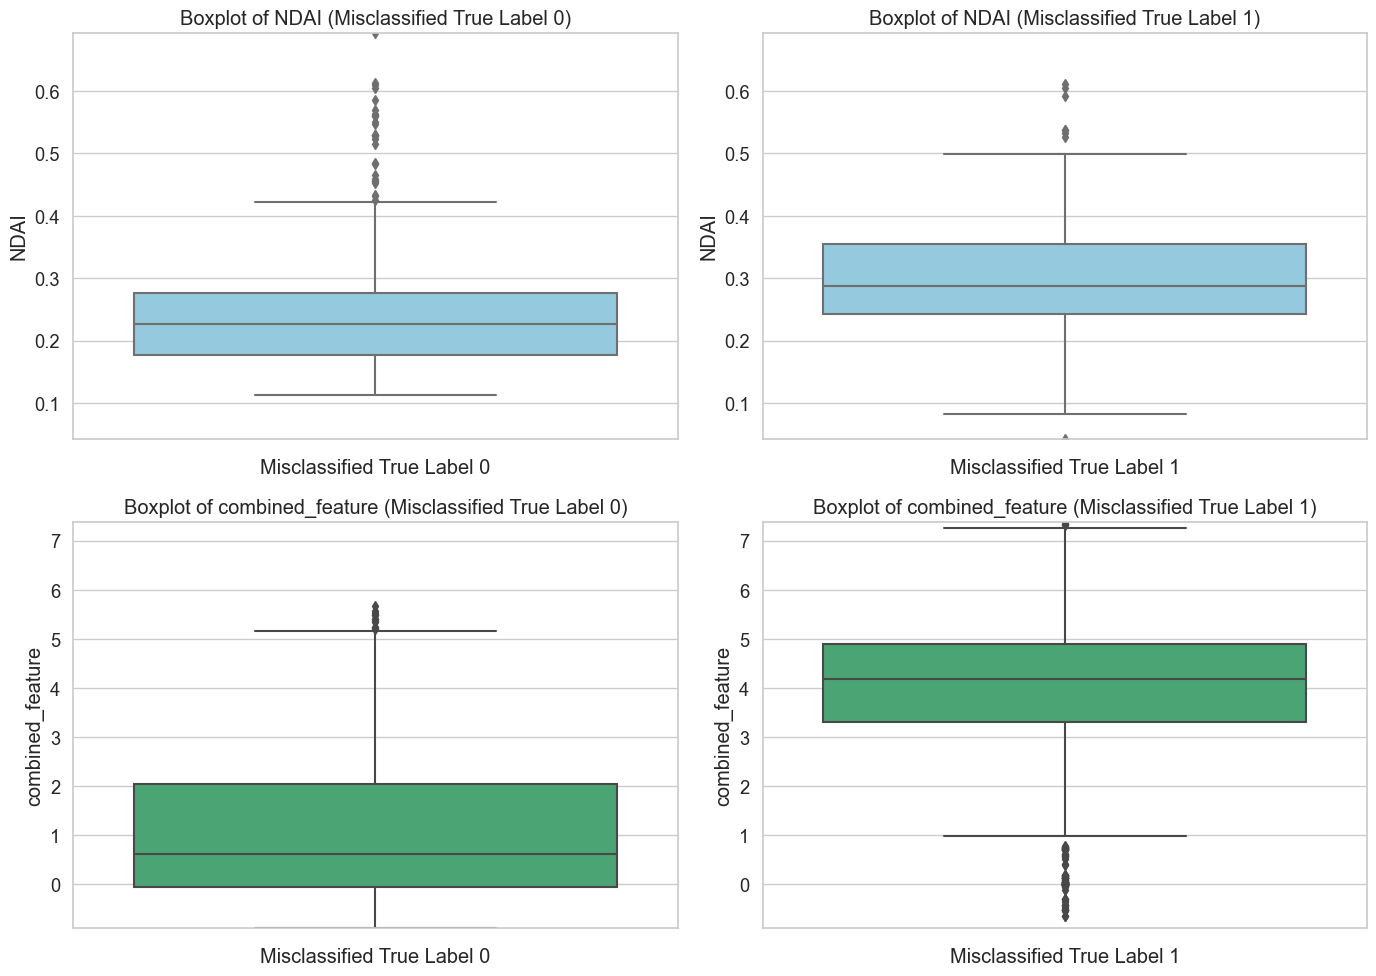

In [28]:
misclassified_df = test_xy.iloc[misclassified_idx].copy()
misclassified_df['true_label'] = y_test.iloc[misclassified_idx].values

misclassified_0 = misclassified_df[misclassified_df['true_label'] == 0].groupby(['x', 'y']).size().reset_index(name='count')
print("Misclassified true label 0:")
print(misclassified_0)
print(misclassified_0.shape)

misclassified_1 = misclassified_df[misclassified_df['true_label'] == 1].groupby(['x', 'y']).size().reset_index(name='count')
print("\nMisclassified true label 1:")
print(misclassified_1)
print(misclassified_1.shape)

# Interested in the edge cases where the misclassified patches are located (patch_size = 9)
# X: [70,368], Y: [2,383]
# We consider when the patch is not fully within the image
condition_0 = (misclassified_0['x'] < 79) | (misclassified_0['x'] > 359) | (misclassified_0['y'] < 11) | (misclassified_0['y'] > 374)
count_misclassified_0 = misclassified_0.loc[condition_0, 'count'].sum()

condition_1 = (misclassified_1['x'] < 79) | (misclassified_1['x'] > 359) | (misclassified_1['y'] < 11) | (misclassified_1['y'] > 374)
count_misclassified_1 = misclassified_1.loc[condition_1, 'count'].sum()

print("Misclassified true label 0 satisfying condition:", count_misclassified_0)
print("Misclassified true label 1 satisfying condition:", count_misclassified_1)

misclassified_df = X_test.iloc[misclassified_idx].copy()
misclassified_df['true_label'] = y_test.iloc[misclassified_idx].values

X_misclassified_0 = misclassified_df[misclassified_df['true_label'] == 0]
X_misclassified_1 = misclassified_df[misclassified_df['true_label'] == 1]

pca_min = min(X_misclassified_0['NDAI'].min(), X_misclassified_1['NDAI'].min())
pca_max = max(X_misclassified_0['NDAI'].max(), X_misclassified_1['NDAI'].max())

combined_min = min(X_misclassified_0['combined_feature'].min(), X_misclassified_1['combined_feature'].min())
combined_max = max(X_misclassified_0['combined_feature'].max(), X_misclassified_1['combined_feature'].max())

sns.set_theme(style="whitegrid", font_scale=1.2)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(y=X_misclassified_0['NDAI'], color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title("Boxplot of NDAI (Misclassified True Label 0)")
axs[0, 0].set_xlabel("Misclassified True Label 0")  
axs[0, 0].set_ylabel("NDAI")
axs[0, 0].set_ylim(pca_min, pca_max)

sns.boxplot(y=X_misclassified_1['NDAI'], color='skyblue', ax=axs[0, 1])
axs[0, 1].set_title("Boxplot of NDAI (Misclassified True Label 1)")
axs[0, 1].set_xlabel("Misclassified True Label 1") 
axs[0, 1].set_ylabel("NDAI")
axs[0, 1].set_ylim(pca_min, pca_max)

sns.boxplot(y=X_misclassified_0['combined_feature'], color='mediumseagreen', ax=axs[1, 0])
axs[1, 0].set_title("Boxplot of combined_feature (Misclassified True Label 0)")
axs[1, 0].set_xlabel("Misclassified True Label 0")
axs[1, 0].set_ylabel("combined_feature")
axs[1, 0].set_ylim(combined_min, combined_max)

sns.boxplot(y=X_misclassified_1['combined_feature'], color='mediumseagreen', ax=axs[1, 1])
axs[1, 1].set_title("Boxplot of combined_feature (Misclassified True Label 1)")
axs[1, 1].set_xlabel("Misclassified True Label 1")  
axs[1, 1].set_ylabel("combined_feature")
axs[1, 1].set_ylim(combined_min, combined_max)

plt.tight_layout()
plt.show()


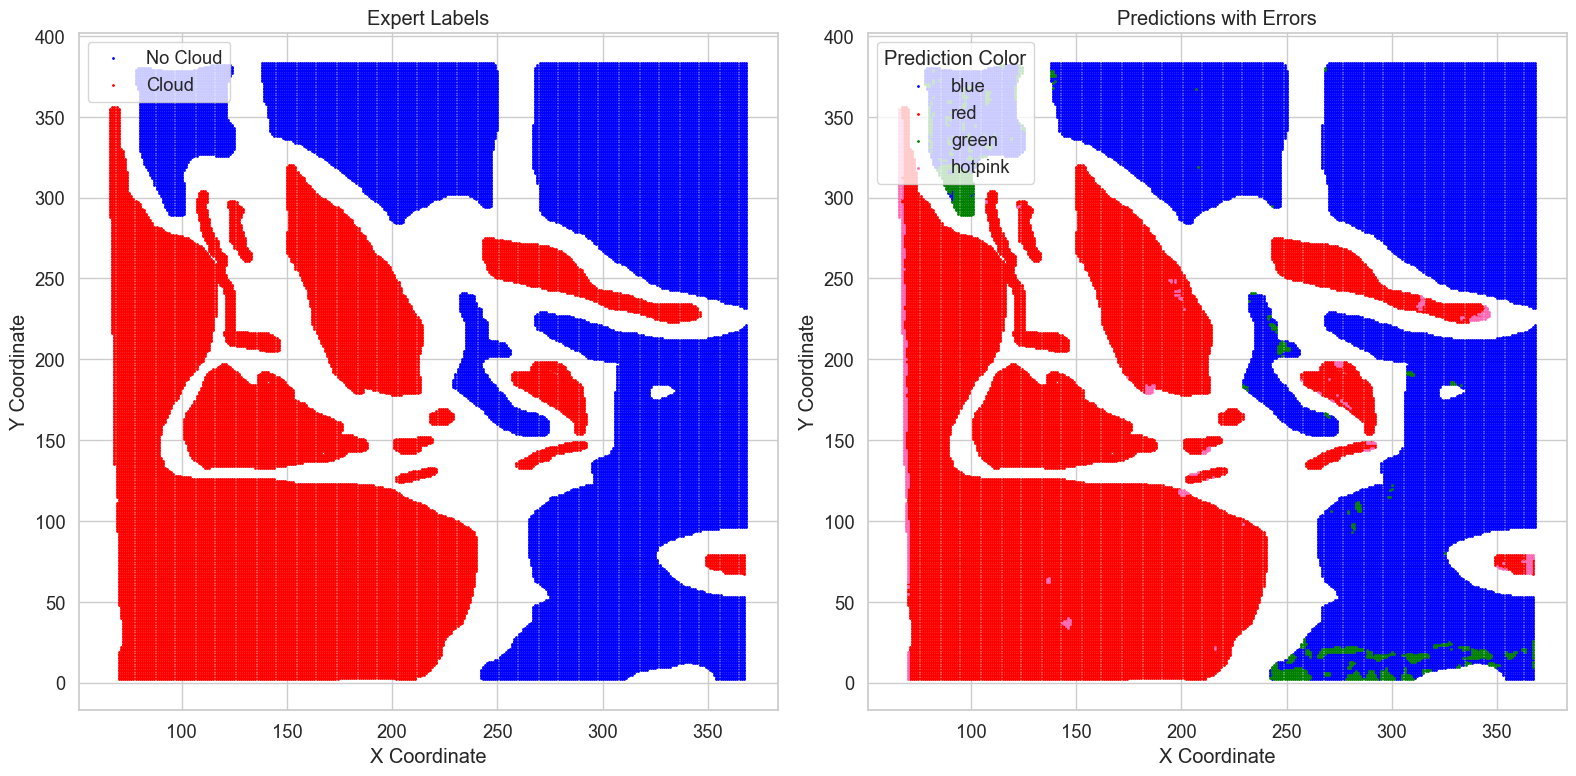

In [29]:
# Prepare data for plotting
hot_expert_df = test_xy.copy()
hot_expert_df['true_label'] = y_test.values
hot_expert_df['pred_label'] = y_pred_lr_best_bi
hot_expert_df['misclassified'] = hot_expert_df['true_label'] != hot_expert_df['pred_label']

def get_color(row):
    if row['misclassified']:
        if row['true_label'] == 0:
            return 'green'      # false positive
        else:
            return 'hotpink'    # false negative
    else:
        # Correctly classified
        return 'blue' if row['true_label'] == 0 else 'red'

hot_expert_df['color'] = hot_expert_df.apply(get_color, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

df_labeled = test_df[test_df["Label"] != 0]
label_colors = {-1: "blue", 1: "red"}
for label, color in label_colors.items():
    subset = df_labeled[df_labeled["Label"] == label]
    axs[0].scatter(subset["x"], subset["y"], s=1, c=color, label="Cloud" if label == 1 else "No Cloud")
axs[0].set_title("Expert Labels")
axs[0].set_xlabel("X Coordinate")
axs[0].set_ylabel("Y Coordinate")
axs[0].legend()

# Plot the predictions with misclassifications
for color in ['blue', 'red', 'green', 'hotpink']:
    subset = hot_expert_df[hot_expert_df['color'] == color]
    axs[1].scatter(subset["x"], subset["y"], s=1, c=color, label=color)
axs[1].set_title("Predictions with Errors")
axs[1].set_xlabel("X Coordinate")
axs[1].set_ylabel("Y Coordinate")
axs[1].legend(title="Prediction Color")

plt.tight_layout()
plt.show()
